In [2]:
pip install torch torchvision


^C
Note: you may need to restart the kernel to use updated packages.


Используемое устройство: cpu


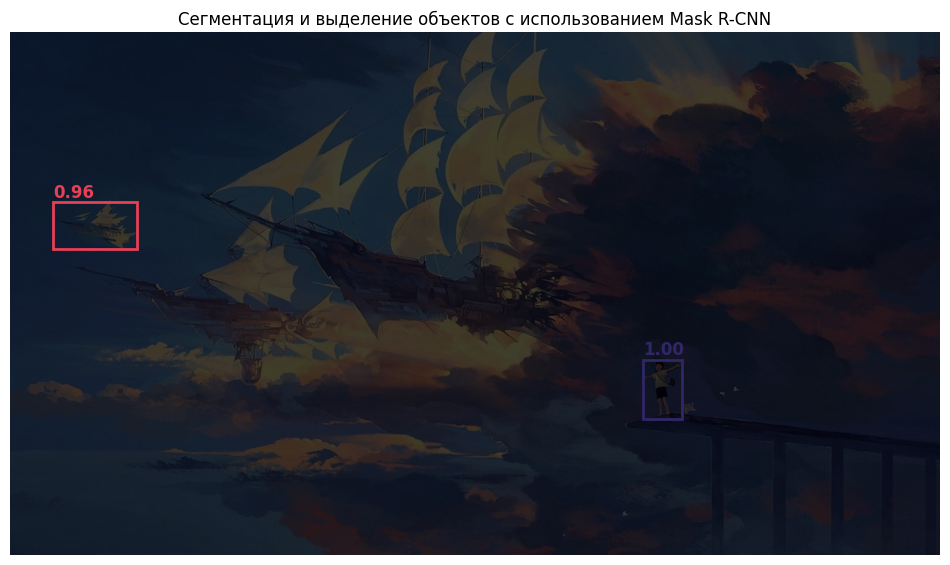

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

def load_image(image_path):
    """
    Загружает изображение и конвертирует его в формат PIL.
    """
    if image_path.startswith('http://') or image_path.startswith('https://'):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_path).convert("RGB")
    return image

def get_transform():
    """
    Возвращает преобразования для изображений.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    return transform

def visualize_predictions(image, masks, boxes, scores, threshold=0.5):
    """
    Визуализирует предсказанные маски и bounding boxes на изображении.
    
    :param image: Исходное изображение в формате PIL.
    :param masks: Предсказанные маски объектов.
    :param boxes: Предсказанные координаты bounding boxes.
    :param scores: Уверенность модели в каждом предсказанном объекте.
    :param threshold: Порог уверенности для отображения объектов.
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    ax = plt.gca()
    
    for i in range(len(masks)):
        if scores[i] >= threshold:
            mask = masks[i, 0].cpu().numpy()
            mask = mask > 0.5  # Порогирование маски
            rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            color = np.random.randint(0, 255, (3,)) / 255.0
            rgb_mask[mask] = color
            ax.imshow(rgb_mask, alpha=0.5)
            
            box = boxes[i].cpu().numpy().astype(int)
            rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                 fill=False, color=color, linewidth=2)
            ax.add_patch(rect)
            ax.text(box[0], box[1]-10, f"{scores[i]:.2f}", color=color, fontsize=12, weight='bold')
    
    plt.axis('off')
    plt.title('Сегментация и выделение объектов с использованием Mask R-CNN')
    plt.show()

# Проверка доступности GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Используемое устройство: {device}")

# Загрузка предобученной модели Mask R-CNN
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

# Путь к изображению (можно заменить на URL или локальный путь)
# Пример локального пути:
image_path = '../images/IMG_20130818_081052.jpg'
# Пример URL:
# image_path = 'https://images.unsplash.com/photo-1601758123927-1e1a7b7e68db'

# Загрузка и преобразование изображения
image = load_image(image_path)
transform = get_transform()
image_tensor = transform(image).to(device)

# Добавление размера батча
image_tensor = image_tensor.unsqueeze(0)

# Предсказание сегментации и объектов
with torch.no_grad():
    predictions = model(image_tensor)

# Извлечение масок, бокс координат и скорингов
masks = predictions[0]['masks']
boxes = predictions[0]['boxes']
scores = predictions[0]['scores']

# Визуализация результатов
visualize_predictions(image, masks, boxes, scores, threshold=0.5)